# Spectral Methods Part I: Chapters 1-3

Ernesto Barraza-Valdez, June 24, 2024

This notebook follows *Implementing Spectral Methods for Partial Differential Equations* by Dr. David Kopriva.

This is the first of several notebooks that covers Chapters 1-3 of Dr. Kopriva's textbook.

In this notebook, you are expected to know some Julia and to follow along the book. 
Because Julia has many useful libraries and packages for linear algebra (such as BLAS) and fourier transforms (such as FFTW) we will put those to use in order to focus more on advanced methods for non-periodic problems. 

In [1]:
#Check if Julia is working by checking version
VERSION

v"1.10.3"

We will activate a project in order to keep all Julia Packages useful for the rest of the notebooks

In [2]:
] activate .

  Activating new project at `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods`


In [3]:
] add BenchmarkTools FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia

   Resolving package versions...
    Updating `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods/Project.toml`
  [28f2ccd6] + ApproxFun v0.13.27
  [6e4b80f9] + BenchmarkTools v1.5.0
  [7a1cc6ca] + FFTW v1.8.0
  [cf66c380] + FastChebInterp v1.2.0
  [442a2c76] + FastGaussQuadrature v1.0.2
⌃ [057dd010] + FastTransforms v0.15.16
  [f67ccb44] + HDF5 v0.17.2
  [7073ff75] + IJulia v1.24.2
  [40713840] + IncompleteLU v0.2.1
  [42fd0dbc] + IterativeSolvers v0.9.4
  [ba0b0d4f] + Krylov v0.9.6
  [b964fa9f] + LaTeXStrings v1.3.1
  [23fbe1c1] + Latexify v0.16.3
  [7a12625a] + LinearMaps v3.11.3
  [5c8ed15e] + LinearOperators v2.8.0
  [91a5bcdd] + Plots v1.40.4
⌅ [f27b6e38] + Polynomials v3.2.13
  [af69fa37] + Preconditioners v0.6.1
  [f2c3362d] + RecursiveFactorization v0.2.23
  [a25cea48] + SpecialPolynomials v0.4.9
  [a759f4b9] + TimerOutputs v0.5.24
  [de0858da] + Printf
  [8dfed614] + Test
    Updating `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods/Manifest.toml`
  [14f7f2

In [4]:
using FFTW
using Base.Threads
using LinearAlgebra
using SparseArrays
using Test
using TimerOutputs
using HDF5
using Printf
using FastGaussQuadrature
using ApproxFun
using FastTransforms
using FastChebInterp
using Polynomials
using SpecialPolynomials
using BenchmarkTools
using Latexify
using Plots
using LaTeXStrings
using IncompleteLU
using Preconditioners 
using IterativeSolvers
using LinearMaps
using RecursiveFactorization
using LinearOperators
using Krylov
using IJulia

# Ch 1: Spectral Approximation
---


## 1.6 Fourier Interpolation

We skip Algorithm 1 because it is just a FFT which we use the FFTW package to implement

In [5]:
#Ch 1.6.1, Page 18
#algorithm 2
#Direct Evaluation of the Fourier Interpolant from Its Modes
function FourierInterpolantFromModes(FK::Array{ComplexF64}, k::Array{ComplexF64}, x::Float64)
    N = length(k)
    s = 0.5 * ( FK[1] * exp(-1.0im * N * x/2)  + FK[end] * exp(1.0im * N * x/2) )
    for i in 2:N-1
        s = s + FK[i]*exp(1.0im * k[i] * x)
        
    end
    return s

end

FourierInterpolantFromModes (generic function with 1 method)

In [6]:
#Ch 1.6.1, Page 18
#algorithm 3
#Direct Evaluation of the Fourier Interpolant from Its Nodes
function FourierInterpolantFromNodes!(Fj::Array{ComplexF64}, xj::Array{ComplexF64}, x::Float64, diffprec::Float64)
    N = length(xj)
    t = 0.0
    s = 0.0
    for j in 1:N
        if abs(x-xj[j]) < diffprec
            return Fj[j]
            
        else
            t = (x - xj)/2.0
            s = s + Fj[j]*sin(N*t)*cot(t)/2
        end
        
    end
    return s

end

FourierInterpolantFromNodes! (generic function with 1 method)

## 1.10 Polynomial Series Truncation

In [7]:
#Ch 1.10.1, pg 31
#algorithm 4
#Evaluate the Legendre Coefficients of the Derivative of a Polynomial
function LegendreDerivativeCoefficients!(dFk1::Array{ComplexF64},Fk::Array{ComplexF64})
    N = length(Fk1)-1
    dFk1[end] = 0
    dFk1[end-1] = (2*N - 1) * Fk[end]

    for k in N-2:-1:0
        kk = k+1
        dFk1[kk] = (2*k +1) * (Fk[kk+1] + dFk1[kk+2]/(2*k+5))
        
    end

    return nothing

end

LegendreDerivativeCoefficients! (generic function with 1 method)

In [8]:
#Ch 1.10.1, pg 31
#algorithm 5
#Evaluate the LChebyshev Coefficients of the Derivative of a Polynomial
function ChebyshevDerivativeCoefficients!(dFk1::Array{ComplexF64},Fk::Array{ComplexF64})
    N = length(Fk1)-1
    dFk1[end] = 0
    dFk1[end-1] = (2*N) * Fk[end]

    for k in N-2:-1:1
        kk = k+1
        dFk1[kk] = 2.0*(k +1) *Fk[kk+1] + dFk1[kk+2]
        
    end

    DFk1[1] = Fk[1] + DFk1[2]/2.0

    return nothing

end

ChebyshevDerivativeCoefficients! (generic function with 1 method)

# Ch 2: Algorithms for Periodic Functions
---

## Ch 2.1-2.2: FFT

We will use the Julia FFTW for DFFT

## Ch 2.3 How to Evaluate the Fourier Interpolation Derivative by FFTT

For this example we will use the function: 

\begin{align}
    f(x) = sin(x)
\end{align}

And calculate it's derivate via Fourier Interpolation which should match the analytical derivative:

\begin{align}
    \frac{d}{d x} f(x) = -cos(x)
\end{align}

Using a total of $N=20$ and $dx = \pi/8$

In [56]:
N = 100
dx = 2.0*pi/N
xx = [-pi + i*dx for i in -0:N]
fx = sin.(pi*xx) .+ 0.0im ; #note that we need to add imaginary zer0 here because FFT is complex

We can calucate the wave numbers using the `FFTW.fftfreq()` function from the FFTW package

**NOTE:** That the total number of nodes are: $N_{total} = N+1$

In [57]:
kxa = fftfreq(Int(N)+1,1/dx);

In [58]:
typeof(kxa)

Frequencies{Float64}

The `FFTW.fftfreq()` function does not return a regular array but it's own array datatype. We need to convert it to a Julia array. We do that by simply using the indexing colons

In [59]:
kx = kxa[:];

In [60]:
typeof(kx)

Vector{Float64} (alias for Array{Float64, 1})

Define the Fourier Derivative:

In [66]:
#Ch 2.3, pg 54
#algorithm 17
#Fast Evaluation of Fourier Polynomial Derivative
function FourierDerivativeByFFT(f::Array{ComplexF64}, k::Array{Float64}, dn::Int64, planf, plani)

    #fourier transform using FFTW plans
    ftran = planf*f
    #create d/dx derivative with wavenumber
    ikderiv = @. 1.0im*kx^dn
    #multiply wavenumbers by the FT(f)
    ftran .= ikderiv.*ftran
    #below is the part from the book that is unnecessary with Julia
    # if mod(dn,2.0) != 0
    #     ftran[end] = 0.0 + 0.0im
    # end
    #inverse fourier transform
    g = plani * ftran
    # @. g = g/(length(g)^2)
    
    return g

end

FourierDerivativeByFFT (generic function with 2 methods)

Let's calculate our derivative. 

We can directly FFT using the `fft()` function. However, for a faster method we can create a FFTW plan such as below. We can either use Julia's in place plans such as `FFTW.plan_fft!()` which will allow us to use the same memory of the array and replace that array with its FFT. Or we create two plans, one for forward and one for backwards. We will do the latter. 

**NOTE:** The Julia `FFTW.jl` package is wraped under the `AbstractFFTs.jl` package which allows you to use the same functions and has better documentation here: https://juliamath.github.io/AbstractFFTs.jl/stable/

Below we set the `flags=FFTW.MEASURE`

In [67]:
#forward plan
fplan = plan_fft(xx; flags=FFTW.MEASURE)
#inverse plan
bplan = plan_bfft(xx; flags=FFTW.MEASURE);

In [68]:
length(kx)

101

In [69]:
length(fx)

101

In [70]:
#number of derivatives to take
dn = 1
df = FourierDerivativeByFFT(fx, kx, dn, fplan, bplan);

We can now plot the results to compare to the analyitcal solutions.

First let's take the real parts

Note that the FFTW functions do not take the normalization into account. So for every FFT you do you need to divide by the $\sqrt{\frac{N+1}{2}}$

In [71]:
fxr = real(fx);
dfxr = real(df)./(N+1).*2.0; #./(2.0*pi);

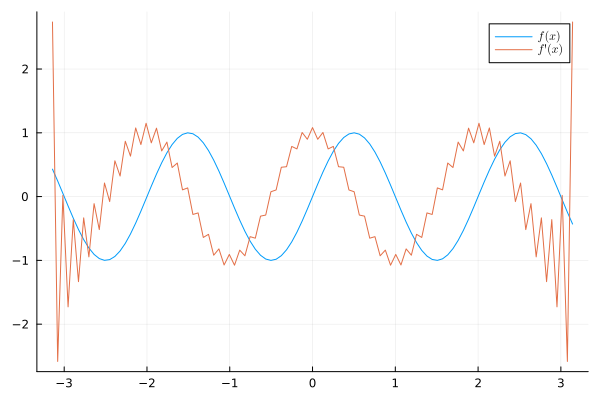

In [72]:
plot(xx, fxr, fmt = :png, label=L"f(x)")
plot!(xx, dfxr, fmt = :png, label=L"f'(x)")

Good enough for now

## Ch 2.4 How to compute derivatives by Matrix Multiplication

We won't go too much into detail in this section because it won't be necessary in the end

In [21]:
#ch 2.4, pg 55
#algorithm 18
#Computation of Fourier Derivative Matrix using negative sum trick
function FourierDerivativeMatrix(N::Int64)

    D = zeros(Float64,(N,N))
    ii= 0
    jj = 0
    for i in 0:(N-1)
        ii = i+1
        D[ii,ii] = 0.0
        for j in 0:(N-1)
            jj = j+1
            if j!=i
                D[ii,jj] = 0.5 * (-1.0)^(i+j) * cot((i-j)*pi/N)
                D[ii,ii] = D[ii,ii] - D[ii,jj]
            end

        end

    end
    return D

end

FourierDerivativeMatrix (generic function with 1 method)

In [22]:
#algorithm 19
#just matrix vector multiplication

# Ch 3: Algorithms for Non-Periodic Functions
---

## 3.1 How to Compute the Legendre and Chebyshev Polynomials

Here we calculate the Legendre polynomials at a certain point in space $x$.

We add the `LegendreSum()` function in order to add the sum of the Legendre Polynimals that approximate the function at point $x$

In [23]:
#ch 3.1 pg 60
#Algorithm 20
#evaluate Legendre Polynomials of Degree k using three term recursion
function LegendrePolynomial(k::Int64, x::Float64)
    if k==0
        return 1.0

    elseif k==1
        return x
    end
    Lk = 0.0
    Lkm2 = 1 # L_{k-2}
    Lkm1 = x #L_{k-1}
    for j in 2:k
        Lk = (2.0*j - 1)/j *x *Lkm1 - (j-1)/j * Lkm2
        Lkm2 = Lkm1
        Lkm1 = Lk
    end

    return Lk
    
end

#sum of Legendre series polynimoals at point x
#
function LegendreSum(k::Int64, x::Float64)

    if k==0
    return 1.0

    elseif k==1
        return x
    end
    Lk = 0.0
    
    Lkm2 = 1 # L_{k-2}
    Lkm1 = x #L_{k-1}
    Lksum = Lkm2 + Lkm1
    for j in 2:k
        Lk = (2.0*j - 1)/j *x *Lkm1 - (j-1)/j * Lkm2
        Lkm2 = Lkm1
        Lkm1 = Lk
        Lksum = Lksum + Lk
    end

    return Lksum
end

LegendreSum (generic function with 1 method)

Let's look at the polynomials to make sure we got them correct

In [24]:
#testing legendre polynomials
xx = [i for i in -1:0.01:1];

l0 = LegendrePolynomial.(0, xx)
l1 = LegendrePolynomial.(1, xx)
l2 = LegendrePolynomial.(2, xx)
l3 = LegendrePolynomial.(3, xx)
l4 = LegendrePolynomial.(4, xx);
l5 = LegendrePolynomial.(5, xx);

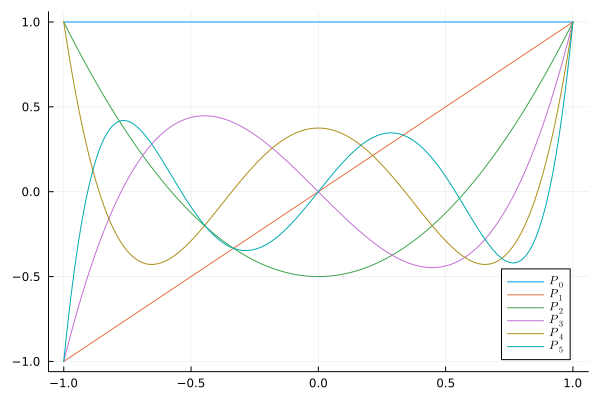

In [25]:
plot(xx, l0, fmt = :png, label=L"P_0")
plot!(xx, l1, fmt = :png, label=L"P_1")
plot!(xx, l2, fmt = :png, label=L"P_2")
plot!(xx, l3, fmt = :png, label=L"P_3")
plot!(xx, l4, fmt = :png, label=L"P_4")
plot!(xx, l5, fmt = :png, label=L"P_5")

Below we calculate the Chebyshev polynomials. We have also added the iteration method. Go ahead and plot to check.

In [26]:
# ch 3.1, page 60
#Algorithm 21
#evaluate Chebyshev Polynomials of Degree k using three term recursion and trigonometric forms
function ChebyshevPolynomialTrig(k::Int64, x::Float64)
    if k==0
        return 1.0

    elseif k==1
        return x
    end

    return cos(k*acos(x))
    
end

function ChebyshevPolynomialIter(k::Int64, x::Float64, Ks::Int64)
    if k==0
        return 1.0

    elseif k==1
        return x
    end
    Tk = 0.0
    Tkm2 = 1 # T_{k-2}
    Tkm1 = x #T_{k-1}
    for j in 2:k
        Tk = 2.0*x *Tkm1 - Tkm2
        Tkm2 = Tkm1
        Tkm1 = Tk
    end

    return Tk
    
end

ChebyshevPolynomialIter (generic function with 1 method)

## Comparing speed of Polynomials Functions vs SpecialPolynomials

As you might have guessed, these polynomials are used in a wide variety of applications. So someone has probably already written something like this in Julia. Yes, the package is `SpecialPolynomials.jl`

We can test it agains our own function to see how fast it is. 

We'll use $N_{total} = N+1 = 31$

In [27]:
#o1 = ones(Float64, 7);
N= 30
i = N+1
xx = 0.1
#Lfunc = (z^2 -1)^N

0.1

In [28]:
#Using SpecialPolynomials package
o1 = zeros(Float64, N+1);
o1[i] = 1.0
Ls = SpecialPolynomials.Legendre(o1)
Ls(xx)

0.14429161321150832

In [29]:
test1 = LegendrePolynomial(N, xx)

0.14429161321150838

Let's define our Legendre Polynomial function calculator that uses the `SpecialPolynomials.jl`

In [30]:
function SPLegendre(j::Int64,x::Float64)
    oo = ones(Float64, j+1);
    Ls = SpecialPolynomials.Legendre(oo)
    return Ls(x)
    

end

SPLegendre (generic function with 1 method)

We will now benchmark with the $N_{total} = N+1 = 17$ at point $x = 0.5$

In [31]:
N = 16
xx = 0.5

0.5

In [32]:
LegendreSum(N,xx)

0.801283226814121

In [33]:
SPLegendre(N,xx)

0.801283226814121

Looks good. Now let's do a speed test with $N_{total} = 1001$

In [34]:
@btime LegendreSum(1000,0.1)

  3.777 μs (0 allocations: 0 bytes)


0.7616876774637876

In [35]:
@btime SPLegendre(1000,0.1)

  11.835 μs (2 allocations: 16.00 KiB)


0.7616876774637886

Our own function `LegendreSum()` is faster. Probably because of all the overhead that comes with packages. 

## 3.2 How to Compute the Gauss Quadrature Nodes and Weights
---

Below we present the calculation of the Legendre Polynomial of degree k and its derivative so that the Gauss nodes and weights can be calcualted

In [36]:
#Ch 3.2.1 pg 63
#Algorithm 22
#The Legendre Polynomial of degree k and its Derivative using Three Term Recursion
function LegendrePolynomialandDerivative(N::Int64, x::Float64)
    Ln =0.0
    Lnm1 = 0.0
    Lnm2 = 0.0
    dLn =0.0
    dLnm1 = 0.0
    dLnm2 = 0.0
    if N==0
        Ln = 1
        dLn = 0
    elseif N==1
        Ln = x
        dLn = 1
    else
        Lnm2 = 1
        Lnm1 = x
        dLnm2 = 0
        dLnm1 = 1

        for j in 2:N
            Ln = (2.0*j - 1)/j *x *Lnm1 - (j-1)/j * Lnm2
            dLn = dLnm2 + (2.0*j-1.0)*Lnm1
            Lnm2 = Lnm1
            Lnm1 = Ln
            dLnm2 = dLnm1
            dLnm1 = dLn
            #Lnsum = Lksum + Lk

        end
        
    end

    return Ln, dLn

end

LegendrePolynomialandDerivative (generic function with 1 method)

In [37]:
#Ch 3.2.1 pg 64
#algorithm 23
function LegendreGaussNodesAndWeights(N::Int64, nit::Int64, TOL::Float64)

    x = zeros(Float64,N+1)
    w = zeros(Float64,N+1)

    if N==0
        x[1] = 0.0
        w[1] = 2.0
    elseif N ==1
        x[1] = -1.0*sqrt(1/3)
        w[1] = 1.0
        x[2] = -x0
        w[2] = w0
    else
        for j in 0:(floor(Int64,((N+1)/2))-1)
            x[j+1] = - cos((2*j+1)/(2*N+2)*pi)
            for k in 0:nit
                Lnp1, dLnp1 = LegendrePolynomialandDerivative(N+1, x[j+1])
                delta = -Lnp1/dLnp1
                x[j+1] = x[j+1] + delta
                if abs(delta) < TOL*abs(x[j+1])
                    break
                end
            end
            Lnp1, dLnp1 = LegendrePolynomialandDerivative(N+1, x[j+1])
            x[end-j] =-x[j+1]
            w[j+1] = 2.0/(1.0 - x[j+1]^2) / dLnp1^2
            w[end-j] = w[j+1]

        end
        
    end
    if mod(N,2) == 0
        Lnp1, dLnp1 = LegendrePolynomialandDerivative(N+1, 0.0)
        x[ceil(Int64,N/2)+1] = 0.0
        w[ceil(Int64,N/2)+1] = 2.0 / dLnp1^2
        
    end

    return x, w


end

LegendreGaussNodesAndWeights (generic function with 1 method)

Now let's test this algorithm. We will test it against the `FastQuadrature.jl` package

In [38]:
xx, ww = LegendreGaussNodesAndWeights(100, 5, 1e-8)

([-0.9997193395298375, -0.9985215119897575, -0.9963677327909441, -0.9932595861878675, -0.9891999908750336, -0.9841928216302206, -0.9782428702864434, -0.9713558345581712, -0.9635383108331345, -0.9547977872711914  …  0.9547977872711914, 0.9635383108331345, 0.9713558345581712, 0.9782428702864434, 0.9841928216302206, 0.9891999908750336, 0.9932595861878675, 0.9963677327909441, 0.9985215119897575, 0.9997193395298375], [0.0007202317062293601, 0.0016758927604990648, 0.002631364873182426, 0.0035844393988022764, 0.004534105010092991, 0.005479434683782079, 0.006419518270177569, 0.007353453674791237, 0.0082803456257234, 0.009199305940921405  …  0.009199305940921405, 0.0082803456257234, 0.007353453674791237, 0.006419518270177569, 0.005479434683782079, 0.004534105010092991, 0.0035844393988022764, 0.002631364873182426, 0.0016758927604990648, 0.0007202317062293601])

In [39]:
## FastGaussQuadrature library
xxx, www = gausslegendre(101)

([-0.9997193395297703, -0.9985215119897575, -0.9963677327909441, -0.9932595861878675, -0.9891999908750336, -0.9841928216302206, -0.9782428702864434, -0.9713558345581712, -0.9635383108331345, -0.9547977872711914  …  0.9547977872711914, 0.9635383108331345, 0.9713558345581712, 0.9782428702864434, 0.9841928216302206, 0.9891999908750336, 0.9932595861878675, 0.9963677327909441, 0.9985215119897575, 0.9997193395297703], [0.0007202317064018636, 0.0016758927604990288, 0.0026313648731823435, 0.003584439398802249, 0.004534105010093023, 0.005479434683782081, 0.006419518270177546, 0.007353453674791277, 0.008280345625723362, 0.009199305940921432  …  0.009199305940921432, 0.008280345625723362, 0.007353453674791277, 0.006419518270177546, 0.005479434683782081, 0.004534105010093023, 0.003584439398802249, 0.0026313648731823435, 0.0016758927604990288, 0.0007202317064018636])

Let's benchmark the time

In [40]:
@btime LegendreGaussNodesAndWeights(100, 100, 1e-8);

  73.251 μs (2 allocations: 1.75 KiB)


In [41]:
@btime gausslegendre(101);

  3.841 μs (6 allocations: 4.84 KiB)


Clearly the `FastQuadrature.jl` is much faster

### 3.2.2 Legendre Gauss-Lobatto Quadrature

For the Guass-Lobatto Legendre points, we want to find the zeros of $L_{n}'$

Unfortunately the book is mistaken on this one. 

$q$ and $q'$ from equation **3.4** should be:

\begin{align}
    q &= L_n'(x) \\
    q' &= L_n''(x)
\tag{3.4a}
\end{align}

From wikipedia: https://en.wikipedia.org/wiki/Legendre_polynomials#Rodrigues'_formula_and_other_explicit_formulas

We have that the second derivative:

\begin{align}
    L_n''(x) = \frac{1}{1-x^2} \left[ 2x\: L_n'(x) - n(n+1) L_n(x) \right]
\end{align}

Thus we only need to change the last part of the algorithm

In [42]:
# Ch 3.2.2 pg 65
#algorithm 24
#Combined algorithm to compute Ln(x), q(x) = L_{N+1}(x) - L_{N-1}, and q'(x)
function qAndLEvaluation(N::Int64, x::Float64)

    k=2
    Lnm2 = 1.0
    Lnm1 = x
    Ln =0.0
    dLn = 0.0
    dLnm2 = 0.0
    dLnm1 = 1.0


    for j in 2:N
        Ln = (2.0*j - 1)/j *x *Lnm1 - (j-1)/j * Lnm2
        dLn = dLnm2 + (2.0*j-1.0)*Lnm1
        Lnm2 = Lnm1
        Lnm1 = Ln
        dLnm2 = dLnm1
        dLnm1 = dLn
        #Lnsum = Lksum + Lk

    end

    q = dLn
    #second derivative from https://en.wikipedia.org/wiki/Legendre_polynomials#Rodrigues'_formula_and_other_explicit_formulas
    dq = (2*x*dLn - N*(N+1)*Ln)/(1-x^2) #ddLn
    
    # k = N+1
    # Lnp1 = (2*k-1)/k * x * Ln - (k-1)/k * Lnm1
    # dLnp1 = dLnm1 + (2*k-1)*Ln

    # q = Lnp1 - Lnm1
    # dq = dLnp1 - dLnm1
    
        
    

    return q, dq, Ln



end

qAndLEvaluation (generic function with 1 method)

In [43]:
# Ch 3.2.2 pg 66
#algorithm 25
#calculates the gauss lobatto nodes and weights
function LegendreGaussLobattoNodesAndWeights(N::Int64, nit::Int64, TOL::Float64)

    x = zeros(Float64,N+1)
    w = zeros(Float64,N+1)
    xold = 0.0

    if N ==1
        x[1] = -1.0
        w[1] = 1.0
        x[2] = 1.0
        w[2] = w[1]
    else
        x[1] = -1.0
        w[1] = 2.0/(N*(N+1))
        x[end] = 1.0
        w[end] = w[1]
        #xold = 0.0
        
        for j in 1:(floor(Int64,((N+1)/2))-1)
            x[j+1] = - cos((j+0.25)/N*pi - 3.0/(8.0*N*pi) /(j + 0.25))
            #println(j)
            #x[j+1] = -cos(pi*j/N)
            for k in 0:nit
                q, dq, Ln = qAndLEvaluation(N, x[j+1])
                delta = -q/dq
                xold = x[j+1]
                x[j+1] = x[j+1] + delta
                if abs(x[j+1] - xold) < TOL #abs(delta) < TOL*abs(x[j])
                    break
                end
                if k==nit-1
                    println("Reached Iterator Max")
                end
            end
            q, dq, Ln = qAndLEvaluation(N, x[j+1])
            x[end-j] =-x[j+1]
            w[j+1] = 2.0/(N*(N+1)) / Ln^2
            w[end-j] = w[j+1]

        end
        
    end
    if mod(N,2) == 0
        q, dq, Ln = qAndLEvaluation(N, 0.0)
        x[ceil(Int64,N/2)+1] = 0.0
        w[ceil(Int64,N/2)+1] = 2.0/(N*(N+1)) / Ln^2
        
    end

    return x, w



end

LegendreGaussLobattoNodesAndWeights (generic function with 1 method)

We can double check that our Legendre-Gauss-Lobatto points are indeed the zeros of $L_n'(x)$

In [44]:
xl, wl = LegendreGaussLobattoNodesAndWeights(10,10000000,1e-12)

([-1.0, -0.934001430408059, -0.7844834736631444, -0.565235326996205, -0.29575813558693936, 0.0, 0.29575813558693936, 0.565235326996205, 0.7844834736631444, 0.934001430408059, 1.0], [0.01818181818181818, 0.10961227326699492, 0.18716988178030533, 0.2480481042640283, 0.2868791247790081, 0.30021759545569066, 0.2868791247790081, 0.2480481042640283, 0.18716988178030533, 0.10961227326699492, 0.01818181818181818])

Using our previous function:

In [45]:
LegendrePolynomialandDerivative(10, xl[9])

(0.31167406997533376, 3.552713678800501e-15)

The $3.0e-15$ is close enough to zero

In [46]:
qAndLEvaluation(10, xl[9])

(3.552713678800501e-15, -89.14566901569283, 0.31167406997533376)

Let's the the Chebyshev version

In [47]:
# Ch 3.2.3 pg 67
#algorithm 26
#Calculates Chebyshev Guass Nodes and Weights
function ChebyshevGaussNodesAndWeights(N::Int64)
    x = zeros(Float64,N+1)
    w = zeros(Float64,N+1)

    for j in 0:N
        x[j+1] = -cos((2*j+1)*pi/(2*N+2))
        w[j+1] = pi/(N+1)

    end

    return x, w

end

ChebyshevGaussNodesAndWeights (generic function with 1 method)

In [48]:
# Ch 3.2.3 pg 68
#algorithm 27
#Calculates Chebyshev Guass Nodes and Weights
function  ChebyshevGaussLobattoNodesAndWeights(N::Int64)

    x = zeros(Float64,N+1)
    w = zeros(Float64,N+1)

    for j in 0:N
        x[j+1] = -cos(pi*j/N)
        w[j+1] = pi/(N)

    end
    w[1] = w[1]/2.0
    w[end] = w[end]/2.0
    
    return x, w

end

ChebyshevGaussLobattoNodesAndWeights (generic function with 1 method)

Let's check our Chebyshev functions with those from the `FastTransforms.jl` package

In [49]:
ChebyshevGaussNodesAndWeights(6)

([-0.9749279121818236, -0.7818314824680298, -0.4338837391175582, -6.123233995736766e-17, 0.43388373911755806, 0.7818314824680295, 0.9749279121818237], [0.4487989505128276, 0.4487989505128276, 0.4487989505128276, 0.4487989505128276, 0.4487989505128276, 0.4487989505128276, 0.4487989505128276])

In [50]:
chebyshevpoints(Float64, 7, Val(1))

7-element FastTransforms.ChebyshevGrid{1, Float64}:
  0.9749279121818236
  0.7818314824680298
  0.4338837391175581
  0.0
 -0.4338837391175581
 -0.7818314824680298
 -0.9749279121818236

Looking pretty good

Let's Benchmark Speed

In [52]:
@btime ChebyshevGaussNodesAndWeights(100);

  1.616 μs (2 allocations: 1.75 KiB)


In [53]:
@btime chebyshevpoints(Float64, 101, Val(1));

  1.589 ns (0 allocations: 0 bytes)


In [54]:
@btime ChebyshevGaussLobattoNodesAndWeights(100);

  1.637 μs (2 allocations: 1.75 KiB)


In [55]:
@btime chebyshevpoints(Float64, 101, Val(2));

  1.590 ns (0 allocations: 0 bytes)


Overall, they are very similar in speed

## 3.3 How to Evaluate Chebyshev Interpolants via the FFT
---

## Chebyshev Tranfrom

The Chebyshev Transform are defined below with the formulas for the Chebyshev transform coefficients ($\tilde{f}_k$) and the inverse back to position space $f_j$ as: 


\begin{align}
\tilde{f}_k &= \frac{2}{N\:\bar{c}_k} \sum^{N}_{j=0} \frac{f_j}{\bar{c}_j} cos\left( \frac{j\cdot k \cdot \pi}{N} \right) \\
f_j &= \sum^{N}_{k=0} \tilde{f}_k cos\left( \frac{j\cdot k \cdot \pi}{N} \right)
\tag{3.11}
\end{align}
ion} lign}




\begin{align}
    \bar{c}_j = \left \{
    \begin{aligned}
        &2, && j=0,N \\
        &1, && j=1,...N-1
    \end{aligned} \right.
\tag{3.12}
\end{align}

We can use the discrete cosine transform (DCT) from the FFTW package:
<br>
http://www.fftw.org/doc/1d-Real_002deven-DFTs-_0028DCTs_0029.html

We see that the closest DCT is the type REDFT00 (DCT-I or DCT type 1). The transform from spatial domain to spectral domain is given by the following equation for a vector of size '$n$' :

\begin{align}
    F_k = f_0 + \left(-1 \right)^k f_{n-1} + 2 \sum_{j=1}^{n-2} f_j cos\left(\frac{j\cdot k \cdot \pi}{n-1} \right)
\tag{REDFT00 \:\:DCT-I}
\end{align}

We first note that our indexing number '$j$' spans:

\begin{align}
    j = 0,1,...,N
\end{align}

Thus, our vector we've been using has a size of: $N+1$

So our '$N$' is related to the FFTW '$n$' as follows: 

\begin{align}
    n = N+1
\end{align}

or

\begin{align}
    N = n-1
\end{align}

Using this relation, we replace the '$n-1$' in the FFTW DCT-I formula:

\begin{align}
    F_k = f_0 + \left(-1 \right)^k f_{N} + 2 \sum_{j=1}^{N-1} f_j cos\left(\frac{j\cdot k \cdot \pi}{N} \right)
\tag{REDFT00 \:\:DCT-I}
\end{align}

Which looks closer to Equation (3.11).

We follow by expanding out the $0^{th}$ and $N^{th}$ terms in Equation (3.11)

\begin{align}
    \tilde{f}_k = \frac{2}{\bar{c}_k\cdot N}\left[ \frac{f_0}{2} + (-1)^k \frac{f_N}{2} + \sum_{j=1}^{N-1} f_j cos \left( \frac{j\cdot k \cdot \pi}{N}\right)  \right]
\end{align}

We can further our expansion by taking into consideration the $k = 0$, $k = N$ and $k = 1,..,N-1$ terms separately:

\begin{align}
    \tilde{f}_{k=0} &= \frac{1}{ N}\left[ \frac{f_0}{2} + \frac{f_N}{2} + \sum_{j=1}^{N-1} f_j   \right] \\
    \tilde{f}_{k=N} &= \frac{1}{ N}\left[ \frac{f_0}{2} + (-1)^N\frac{f_N}{2} + \sum_{j=1}^{N-1} f_j cos \left( j\cdot  \pi\right)  \right] \\
    \tilde{f}_{k \neq 0,N} &= \frac{1}{ N}\left[ f_0 + (-1)^k f_N + 2 \sum_{j=1}^{N-1} f_j cos \left( \frac{j\cdot k \cdot \pi}{N}\right)  \right]
\end{align}

The last relation for $k \neq 0,N$ is exactly the FFTW DCT-I (REDFT00). The coefficients for $k = 0,N$ are also of type DCT-I but they are divided by $2$.

Therefore, the Chebyshev transform (of the first kind) with Guass-Lobatto points (of the second kind) is simply the FFTW DCT-I (REDFT00) with the resulting spectrum coefficients at $k=0,N$ divided by $2$ 

And the inverse is also a FFTW DCT-I (REDFT00) but rather we need to divide the spectral coefficients of $k=1,..,N-1$ by $2$ prior to the inverse transform. 

Below we show the Chebyshev Transforms using FFTW functions

In [73]:
#gauss points
function FastChebyshevTransform1(g::Array{Float64}, plan)
    n = length(g)
    ftran = plan*g #pr*g;
    @. ftran = sqrt(2.0/n)*ftran;
    ftran[1] = ftran[1]/sqrt(2.0)
    return ftran

end

function InvFastChebyshevTransform1(g::Array{Float64}, plan)
    n = length(g)
    ftran = plan*g #pr*g;
    #@. ftran = sqrt(2.0/n)*ftran;
    ftran[1] = ftran[1]*sqrt(2.0)
    return ftran

end

# #gauss lobatto points
# function FastChebyshevTransform2(g::Array{Float64}, plan)
#     ftran  = plan*g 
#     @. ftran = 1.0/(n-1)* ftran;
#     ftran[1] = ftran[1]/2.0
#     ftran[end] = ftran[end]/2.0
#     return ftran
# end


# function InvFastChebyshevTransform2(g::Array{Float64}, plan)
#     ff = zeros(length(g))
#     @. ff = g
#     ff[1] = ff[1]*2.0
#     ff[end] = ff[end]*2.0
#     ftran = plan*ff #pr*g;
#     @. ftran = ftran/2.0;
#     return ftran

# end

InvFastChebyshevTransform1 (generic function with 1 method)

In [74]:
#gauss lobatto points
function FastChebyshevTransform2(g::Array{Float64}, plan)
    #println("FCT2")
    n = length(g)
    nscale = 1.0/(n-1)#1/sqrt(2*(n-1)) /(n-1)  #
    ft = deepcopy(g)
    # ft[1] = g[1]/2.0
    # ft[end] = g[end]/2.0
    ftran  = plan*ft 
    @. ftran = nscale*ftran
    # @. ftran = 1.0/(n-1)* ftran;
    ftran[1] = ftran[1]/2.0#*sqrt(0.5)
    ftran[end] = ftran[end]/2.0#*sqrt(0.5)
    return ftran
end


function InvFastChebyshevTransform2(g::Array{Float64}, plan)
    #println("IFCT2")
    n = length(g)
    nscale = 1.0#/(2*(n-1))#1.0/sqrt(2*(n-1))
    ft = deepcopy(g)
    @. ft[2:end-1] = ft[2:end-1]/2.0
    #ft[1] = g[1]*2.0
    #ft[end] = g[end]*2.0
    ftran  = plan*ft 
    @. ftran = nscale*ftran
    # @. ftran = 1.0/(n-1)* ftran;
    #ftran[1] = ftran[1]*2.0
    #ftran[end] = ftran[end]*2.0
    return ftran

end

InvFastChebyshevTransform2 (generic function with 1 method)

In [75]:
#algorithm 5b
#this algorithm takes algorithm 5 and changes to give the mth derivative of the Chebyshev coefficients
function mthChebyshevDerivativeCoefficients(m::Int64, Fk::Array{Float64})
    N = length(Fk)-1
    #dFk = zeros(Float64, N+1)
    #@. dFk = Fk
    dFk = deepcopy(Fk)
    dFkm = zeros(Float64,N+1)

    for l in 1:m
        @. dFkm = 0.0
        dFkm[end] = 0.0
        dFkm[end-1] = 2.0*N * dFk[end]
        # dFkm[end-l+1] = 0
        # dFkm[end-l] = (2*(N-l+1)) * dFk[end-l+1]
    
        #for k in N-2:-1:1
        for k in N-2:-1:1
            kk = k+1
            dFkm[kk] = 2.0*(k +1) *dFk[kk+1] + dFkm[kk+2]
            
        end
    
        dFkm[1] = dFk[2] + dFkm[3]/2.0
        @. dFk = dFkm
        
    end

    return dFkm

end

mthChebyshevDerivativeCoefficients (generic function with 1 method)

### Testing Chebyshev Transform of 1st Kind with Gauss Points

First we make plans

In [77]:
n = 20
p_2 = chebyshevpoints(Float64,n, Val(2))
f = exp.(p_2)
pcos = FFTW.plan_dct(f, flags=FFTW.MEASURE)
pcosp = FFTW.plan_dct(f, flags=FFTW.PATIENT)
ipcos = FFTW.plan_idct(f, flags=FFTW.MEASURE)
ipcosp = FFTW.plan_idct(f, flags=FFTW.PATIENT)
pr = FFTW.plan_r2r(f, FFTW.REDFT10,flags=FFTW.MEASURE);
pr0 = FFTW.plan_r2r(f, FFTW.REDFT00,flags=FFTW.MEASURE);
#ipr0 = FFTW.plan_r2r(f, FFTW.REDFT00,flags=FFTW.MEASURE);
#pr = FFTW.plan_r2r(f, FFTW.REDFT00,flags=FFTW.MEASURE);


Let's test against the `FastTransforms.jl` package.

Frst let's make suer that our cosine transform is equivalent to the Chebyshev transform.

Let's test against:

\begin{align}
    f(x) = e^{x}
\end{align}

In [81]:
#FastTransforms.jl
#n=20
p_2 = chebyshevpoints(Float64,n, Val(1))
f = exp.(p_2)
ftcos = chebyshevtransform(f, Val(1))
#check to see if the chebysheve transform of the first kind is the cosine transform with the points
ff = x -> [cos(k*acos(x)) for k=0:n-1]' * ftcos
ff(0.1) ≈ exp(0.1)

true

Now let's test to see if the inverse is true

In [82]:
iftcos = ichebyshevtransform(ftcos, Val(1))
iftcos ≈ exp.(p_2)

true

Now let's use our Cosine Transform Plan from `FFTW.jl` will result in the same transform as `FastTransforms.jl` 

In [83]:
g =  exp.(p_2)
dct_result  = pcos*g 
dct_result[1] = dct_result[1]/sqrt(2.0)
kk = [convert(Float64,i) for i in 0:n-1]
cheb_coef = @. sqrt(2.0/n) * dct_result; #* cos((2.0*kk + 1.0) * pi / (2.0*n));

We can check the two by looking at the transform coefficeints

In [84]:
for i in 1:n
    println(cheb_coef[i],"\t", ftcos[i])

end

1.2660658777520084	1.2660658777520084
1.13031820798497	1.13031820798497
0.27149533953407656	0.27149533953407656
0.04433684984866379	0.04433684984866379
0.005474240442093735	0.005474240442093735
0.0005429263119139438	0.0005429263119139438
4.4977322954284036e-5	4.4977322954284036e-5
3.1984364624321173e-6	3.1984364624321173e-6
1.992124807428921e-7	1.992124807428921e-7
1.103677176783866e-8	1.103677176783866e-8
5.505896293991498e-10	5.505896293991498e-10
2.4979595727289212e-11	2.4979595727289212e-11
1.039076711834999e-12	1.039076711834999e-12
3.9894598922681805e-14	3.9894598922681805e-14
1.4143579970399278e-15	1.4143579970399278e-15
2.925177461365891e-17	2.925177461365891e-17
-1.2836953722228373e-17	-1.2836953722228373e-17
2.7755575615628915e-18	2.7755575615628915e-18
5.551115123125783e-18	5.551115123125783e-18
2.2204460492503132e-17	2.2204460492503132e-17


Looks good. Now let's do the inverse transform. Remember we need to account for the normalization.

In [85]:
#inverse transform
gf = dct_result
gf[1] = gf[1]*sqrt(2.0)
igf  = ipcos*dct_result;
#dct_result[1] = dct_result[1]/sqrt(2.0)
#kk = [convert(Float64,i) for i in 0:n-1]
#cheb_coef = @. sqrt(2.0/n) * dct_result; #* cos((2.0*kk + 1.0) * pi / (2.0*n));

In [98]:
println("f(x)\t\t | \t Inv Fast \t |  \tFFTW Inv Cos \t ")
println("--------------------------------------------------------------------")
for i in 1:n
    println(exp.(p_2)[i], "\t", igf[i],"\t", iftcos[i])

end

f(x)		 | 	 Inv Fast 	 |  	FFTW Inv Cos 	 
--------------------------------------------------------------------
2.7099151751880792	2.7099151751880797	2.7099151751880792
2.644203591629393	2.644203591629393	2.644203591629393
2.5190441714069842	2.5190441714069842	2.5190441714069842
2.345832065543048	2.3458320655430485	2.345832065543048
2.139144463312138	2.1391444633121384	2.139144463312138
1.9144838347864195	1.9144838347864197	1.9144838347864193
1.6862355593138167	1.686235559313817	1.6862355593138165
1.4662138007571095	1.4662138007571097	1.4662138007571095
1.2629438236251356	1.262943823625136	1.2629438236251358
1.0816191114149023	1.0816191114149027	1.0816191114149025
0.9245398767888507	0.924539876788851	0.9245398767888507
0.7918008555040988	0.7918008555040993	0.7918008555040991
0.682028773350537	0.6820287733505374	0.6820287733505371
0.5930369541055889	0.5930369541055891	0.5930369541055889
0.5223340003346439	0.5223340003346442	0.5223340003346439
0.46747660906063965	0.46747660906064015	0.467

### Chebyshev Transform of 2nd Kind with Gauss-Lobatto Points 

Let's test the 2nd kind with Gauss-Lobatto points similar to what we did above

In [99]:
#FastTransforms.jl
#n=20
p_2 = chebyshevpoints(Float64,n, Val(2))
f = exp.(p_2)
ftcos = chebyshevtransform(f, Val(2))
ff = x -> [cos(k*acos(x)) for k=0:n-1]' * ftcos
ff(0.1) ≈ exp(0.1)

true

In [100]:
iftcos2 = ichebyshevtransform(ftcos, Val(2))
iftcos2 ≈ exp.(p_2)

true

Check if our R2R transform is the same as the `FastTransforms.jl`

In [102]:
g =  exp.(p_2)
#g[1] = g[1]/2.0;
#g[end] = g[end]/2.0;
#dct_result  = pr0*g 
dct_result  = pr0*g 
#dct_result[1] = dct_result[1]/sqrt(2.0)
kk = [convert(Float64,i) for i in 0:n-1]
cheb_coef =@. 1.0/(n-1)* dct_result;#1.0/n * dct_result;# *  cos((2.0*kk + 1.0) * pi / (2.0*n));
cheb_coef[1] = cheb_coef[1]/2.0
cheb_coef[end] = cheb_coef[end]/2.0

-9.349246523159212e-17

In [103]:
for i in 1:n
    println(cheb_coef[i],"\t", ftcos[i])

end

1.2660658777520084	1.2660658777520084
1.1303182079849698	1.1303182079849698
0.2714953395340765	0.2714953395340765
0.044336849848663776	0.044336849848663776
0.005474240442093689	0.005474240442093689
0.0005429263119138918	0.0005429263119138918
4.497732295426474e-5	4.497732295426474e-5
3.1984364624061647e-6	3.1984364624061647e-6
1.9921248065672248e-7	1.9921248065672248e-7
1.10367717243241e-8	1.1036771724324101e-8
5.505896078155842e-10	5.505896078155842e-10
2.4979592544356692e-11	2.4979592544356692e-11
1.0391751597895867e-12	1.0391751597895869e-12
3.989751580100351e-14	3.989751580100351e-14
1.3815702967621603e-15	1.3815702967621603e-15
2.1912296538654406e-17	2.1912296538654406e-17
8.764918615461762e-17	8.764918615461762e-17
1.4023869784738819e-16	1.4023869784738819e-16
1.8698493046318425e-16	1.8698493046318425e-16
-9.349246523159212e-17	-9.349246523159212e-17


Now check the inverses

In [104]:
#inverse Gauss-Lobatto
gf2 = zeros(length(cheb_coef))
@. gf2 = cheb_coef
gf2[1] = gf2[1]*2.0
gf2[end] = gf2[end]*2.0
igf2  = pr0*gf2;
igf2 = @. igf2/2.0;


In [107]:
println("f(x)\t\t | \t Inv Fast2 \t |  \tFFTW Inv R2R \t ")
println("--------------------------------------------------------")
for i in 1:n
    println(exp.(p_2)[i], "\t", igf2[i],"\t", iftcos2[i])

end

f(x)		 | 	 Inv Fast2 	 |  	FFTW Inv R2R 	 
--------------------------------------------------------
2.718281828459045	2.7182818284590455	2.7182818284590455
2.6814596811668983	2.6814596811668974	2.6814596811668974
2.5749168483737988	2.574916848373799	2.574916848373799
2.409631307131501	2.4096313071315008	2.4096313071315008
2.2015034413494527	2.201503441349453	2.201503441349453
1.9685191737244911	1.9685191737244911	1.9685191737244911
1.7279714670512651	1.7279714670512654	1.7279714670512651
1.4943561193225494	1.4943561193225499	1.4943561193225499
1.2782417325138706	1.2782417325138706	1.2782417325138709
1.0860848459354064	1.0860848459354069	1.0860848459354069
0.9207383785368403	0.9207383785368404	0.9207383785368404
0.7823246374794359	0.7823246374794366	0.7823246374794366
0.6691845317656541	0.6691845317656543	0.6691845317656543
0.57871325948829	0.5787132594882904	0.5787132594882904
0.5079960679823977	0.5079960679823976	0.5079960679823976
0.45423503830047673	0.4542350383004776	0.454235038300

### Speed Benchmark

In [108]:
p = chebyshevpoints(Float64,n, Val(1))
g =  exp.(p);
#FastChebyshevTransform1(g, pcosp);
#FastChebyshevTransform1(g, pr0);

In [109]:
#Fast Transform.jl
@btime FastTransforms.chebyshevtransform(g, Val(1));

  9.717 μs (23 allocations: 1.09 KiB)


In [110]:
@btime FastChebyshevTransform1(g, pcosp);

  616.653 ns (7 allocations: 464 bytes)


In [111]:
p = chebyshevpoints(Float64,n, Val(2))
g =  exp.(p);

In [112]:
@btime chebyshevtransform(g, Val(2));

  106.843 μs (137 allocations: 9.30 KiB)


In [113]:
#pr = FFTW.plan_r2r(f, FFTW.REDFT10,flags=FFTW.MEASURE);
#pr0 = FFTW.plan_r2r(f, FFTW.REDFT00,flags=FFTW.MEASURE);
@btime FastChebyshevTransform2(g, pr0);

  11.558 μs (101 allocations: 8.41 KiB)


In [114]:
@btime FastChebInterp.chebcoefs(g);

  99.566 μs (103 allocations: 8.36 KiB)


For whatever reason, our own transforms using the `FFTW.jl` package is faster

In [72]:
#chebyshevtransform(g, Val(2))

In [73]:
#FastChebyshevTransform2(g, pr0)

In [74]:
#FastChebInterp.chebcoefs(g)

In [75]:
#p

In [76]:
#chebpoints(20, -1, 1)

In [77]:
#c = chebinterp(g, p[1], p[end])

In [78]:
#?chebyshevtransform()

# 3.4 How to Evaluate Polynomial Interpolants in Lagrange Form
---

In this section we will just write our algorithms. We will get a better look at them in the next notebook. 

In [115]:
#ch 3.4 pg 75
#Algorithm 30
#Weights for Lagrange Interpolation
function BarycentricWeights(x::Array{Float64})

    n = length(x)-1
    w = ones(length(x))

    for j in 1:n
        jj=j+1
        for k in 0:j-1
            kk=k+1
            w[kk] = w[kk]*(x[kk] - x[jj])
            w[jj] = w[jj]*(x[jj] - x[kk])
            
        end
    end

    @. w = 1.0 / w

    return w


end

BarycentricWeights (generic function with 1 method)

In [116]:
#ch 3.4 pg 75
#Algorithm 31 
#Lagrange Interpolant from Barycentric Form
function LagrangeInterpolation(x::Float64, xx::Array{Float64}, f::Array{Float64}, w::Array{Float64},xtol::Float64)

    numerator = zeros(Float64, length(f))
    denominator = zeros(Float64, length(f))
    t = 0.0

    for j in 1:N
        if abs(x-xx[j]) < xtol
            return f[j]
        end
        t = w[j]/(x-xx[j])
        numerator = numerator + t * f[j]
        denominator = denominator + t

    end

    return numerator/denominator

end

LagrangeInterpolation (generic function with 1 method)

In [84]:
# #Algorithm 32
# function PolynomialInterpolationMatrix(x::Array{Float64}, xx::Array{Float64}, w::Array{Float64},xtol::Float64)

#     T = zeros((length(xx), length(x)))
#     rowhasmatch = false
#     M = length(xx)
#     N = length(x)
#     s = 0.0
#     t = 0.0
#     for k in 1:M
#         rowhasmatch = false
#         for j in 1:N
#             T[k,j] = 0.0
#             if abs(x[j] - xx[k]) < xtol
#                 rowhasmatch = true
#                 T[k,j] = 1.0
#             end
#             if rowhasmatch
#                 s = 0.0
#                 for j in 1:N
#                     t = w[j]/(xx[k] - x[j])
#                     T[k,j] = t
#                     s = s+t

#                 end
#                 for j in 1:N
#                     T[k,j] = T[k,j]/s
#                 end

#             end
            
#         end

#     end

#     return T

# end



In [117]:
#ch 3.4 pg 76
#Algorithm 32
#matrix for interpolation between two sets of points
function PolynomialInterpolationMatrix(x::Array{Float64}, xx::Array{Float64}, w::Array{Float64},xtol::Float64)

    T = zeros((length(xx), length(x)))
    rowhasmatch = false
    M = length(xx)-1
    N = length(x)-1
    s = 0.0
    t = 0.0
    for k in 0:M
        kk = k+1
        rowhasmatch = false
        for j in 0:N
            jj = j+1
            T[kk,jj] = 0.0
            if abs(x[jj] - xx[kk]) < xtol
                rowhasmatch = true
                T[kk,jj] = 1.0
            end
        end
        if !rowhasmatch
            s = 0.0
            for j in 0:N
                jj=j+1
                t = w[jj]/(xx[kk] - x[jj])
                T[kk,jj] = t
                s = s+t

            end
            for j in 0:N
                jj=j+1
                T[kk,jj] = T[kk,jj]/s
            end
        end
    end

    return T

end


PolynomialInterpolationMatrix (generic function with 1 method)

In [86]:
#Algorithm 33
#function  InterpolateToNewPoints
#Is just matrix b y vector mulitplication

In [87]:
#ch 3.4 pg 77
#Algorithm 34
# 
function LagrangeInterpolatingPolynomials(x::Float64, xx::Array{Float64}, w::Array{Float64},xtol::Float64)
    N = length(xx)-1
    lag = zeros(Float64, N+1)
    xMatchesNode = false
    s = 0.0
    t=0.0
    for j in 0:N
        jj=j+1
        lag[jj] = 0.0
        if abs(x - xx[jj]) < xtol
            lag[jj] = 1.0
            xMatchesNode = true
        end
        
    end
    if xMatchesNode
        return lag
    end
    s = 0.0
    for j in 0:N
        jj=j+1
        t = w[jj]/(x-xx[jj])
        lag[jj] = t
        s = s + t
    end

    @. lag = lag/s

    return lag

end

LagrangeInterpolatingPolynomials (generic function with 1 method)

In [118]:
#Ch 3.5 pg 79
#Algorithm 35
#interpolation from Coarse to Fine grid in 2D
function CoarseToFineInterpolation2D(x::Array{Float64},  y::Array{Float64}, f::Matrix{Float64}, xx::Array{Float64},  yy::Array{Float64},xtol::Float64)

    w = BarycentricWeights(x)
    #Tnewold = PolynomialInterpolationMatrix(x, xx, w,xtol)
    T = PolynomialInterpolationMatrix(x, xx, w,xtol)
    Nold = length(x)
    Mold = length(y)
    Nnew = length(xx)
    Mnew = length(yy)

    #for j in 1:Mold
    #end
    #just need matrix multiplication by vector
    #Fnewold = [Tnewold * f[:,j] for j in 1:Mold]
    F = [T * f[:,j] for j in 1:Mold]

    w = BarycentricWeights(xx)
    T = PolynomialInterpolationMatrix(y, yy, w,xtol)
    F = [T * F[j,:] for j in 1:Nnew]

    return F
    

end

CoarseToFineInterpolation2D (generic function with 1 method)

In [119]:
#Ch 3.5.1 pg 80
#Algorithm 36
#Direct Computation of the Polynomial derivative in Barycentric Form
function LagrangeInterpolantDerivative(x::Float64, xx::Array{Float64}, f::Array{Float64}, w::Array{Float64},xtol::Float64)

    numerator = 0.0
    denominator = 0.0
    atNode = false
    i = zero(Int64)
    p = 0.0
    t = 0.0
    
    N = length(x)
    for j in 1:N
        if abs(x - xx[j]) < xtol
            atNode = true
            p = f[j]
            denominator = -w[j]
            i = j
            
        end
    end

    if atNode
        for j in 1:N
            if j != i
                numerator = numerator +w[j] *(p-f[j])/(x - xx[j])
            end

        end
    else
        denominator = 0.0
        p = LagrangeInterpolation(x, xx, f, w,xtol)
        for j in 1:N
            t = w[j]/(x - xx[j])
            numerator = numerator + t*(p-f[j])/(x - xx[j])
            denominator  = denominator +t
        end

    end

    return numerator/denominator
    

end

LagrangeInterpolantDerivative (generic function with 1 method)

In [90]:
# #Algorithm 37
# function PolynomialDerivativeMatrix(x::Array{Float64})

#     N = length(x)
#     w = BarycentricWeights(x)
#     D = zeros(Float64, (N,N))

#     for i in 1:N
#         D[i,i] = 0.0
#         for j in 1:N
#             if j != i
#                 D[i,j] = w[j]/w[i] /(x[i] - x[j])
#                 D[i,i] = D[i,i] - D[i,j]
#             end
#         end

#     end
#     return D

# end

In [120]:
#Ch 3.5.2 pg 82
#Algorithm 37
#First derivative approximation matrix
function PolynomialDerivativeMatrix(x::Array{Float64})

    N = length(x)-1
    w = BarycentricWeights(x)
    D = zeros(Float64, (N+1,N+1))

    for i in 0:N
        ii = i+1
        D[ii,ii] = 0.0
        for j in 0:N
            jj=j+1
            if j != i
                D[ii,jj] = w[jj]/w[ii] /(x[ii] - x[jj])
                D[ii,ii] = D[ii,ii] - D[ii,jj] #+ 1/(x[jj] - x[ii]) #
            end
        end

    end
    return D

end

PolynomialDerivativeMatrix (generic function with 1 method)

In [92]:
#Algorithm 38
function mthOrderPolynomialDerivativeMatrix(m::Int64, x::Array{Float64})
    N = length(x)-1
    w = BarycentricWeights(x)
    #D = zeros(Float64, (N,N))

    D = PolynomialDerivativeMatrix(x)

    if m == 1
        return D
    end

    Dm = zeros(Float64, size(D))
    
    for k in 2:m
        for i in 0:N
            ii=i+1
            Dm[ii,ii] = 0.0
            for j in 0:N
                jj = j+1
                if j != i
                    Dm[ii,jj] = k /(x[ii] - x[jj]) *  (w[jj]/w[ii] * D[ii,ii] - D[ii,jj] )
                    Dm[ii,ii] = Dm[ii,ii] - Dm[ii,jj] # this might be Dm[ii,ii] - Dm[ii,jj]
                end
            end
        end
        @. D = Dm
    end

    return Dm
end

mthOrderPolynomialDerivativeMatrix (generic function with 1 method)

In [93]:
#alg 39
function EOMatrixDerivative(f::Array{Float64}, D::Matrix{Float64})

    N = length(f)
    Df = zeros(Float64, N)


    #M = floor(Int64,(N+1)/2)
    #N will be to total number of points including 0th point
    M = floor(Int64,N/2)
    MM = M+1 #because Julia starts from 1
    ej = zeros(Float64, M)
    oj = zeros(Float64, M)
    De = zeros(Float64, M)
    Do = zeros(Float64, M)

    jj = zero(Int64)
    ii = zero(Int64)

    for j in 0:M
        jj = j+1
        ej[jj] =  0.5 * (f[jj] + f[N -j])
        oj[jj] =  0.5 * (f[jj] - f[N -j])
    end
    for i in 0:M-1
        ii = i+1
        De[ii] = 0.0
        Do[ii] =  0.0
        for j in 0:M-1
            jj = j+1
            De[ii] = De[ii] + (D[ii,jj] + D[ii,N-j])*ej[jj]
            Do[ii] = Do[ii] + (D[ii,jj] - D[ii,N-j])*oj[jj]
        end
    end

    if mod(N,2) != 0
        for i in 0:M-1
            ii = i+1
            De[ii] = De[ii] + D[ii,M] *ej[M]
        end
        De[M+1] = 0.0
        for j in 0:M-1
            jj = j+1
            Do[M] = Do[M] + (D[M,jj] - D[M,N-j]) *oj[jj]
        end
    end

    @views @. Df[1:M] = De + Do
    @views @. Df[M+1:end] = -De[end:-1:1] + Do[end:-1:1]

    if mod(N,2) != 0
        Df[M] = De[M] + Do[M]
    end

    return Df

end

EOMatrixDerivative (generic function with 1 method)

In [94]:
#Alg 40
function FastChebyshevDerivative(f::Array{Float64}, GaussLob::Bool, planf, planb)

    N = length(f)-1
    fk = zeros(Float64, N+1)
    dfk = zeros(Float64, N+1)
    DF = zeros(Float64, N+1)

    if GaussLob
        fk = FastChebyshevTransform2(f, planf)
    elseif !Gausslob
        fk = FastChebyshevTransform1(f, planf)
    end

    ChebyshevDerivativeCoefficients!(dfk,fk);
    if GaussLob
        DF = InvFastChebyshevTransform2(dfk, planb)
    elseif !Gausslob
        DF = InvastChebyshevTransform1(dfk, planb)
    end

    return DF    

end

FastChebyshevDerivative (generic function with 1 method)

# Conclusion

This concludes **Part I** of the textbook! Hooray! 

Now let's move on and solve some real problems